[![](https://img.shields.io/badge/Source%20on%20GitHub-orange)](https://github.com/laminlabs/rxrx-lamin/blob/main/docs/notebooks/02-rxrx1.ipynb)
[![lamindata](https://img.shields.io/badge/Source%20%26%20report%20on%20LaminHub-mediumseagreen)](https://lamin.ai/laminlabs/rxrx/record/core/Transform?uid=Zo0qJt4IQPsbxM)

# Register the RxRx1 dataset

In [1]:
!lamin load laminlabs/rxrx

💡 loading db URL from local cache
💡 loaded instance: laminlabs/rxrx


In [2]:
import lamindb as ln
import lnschema_bionty as lb
import lnschema_lamin1 as ln1

💡 lamindb instance: laminlabs/rxrx


In [3]:
ln.track()

💡 notebook imports: lamindb==0.59.0 lnschema_bionty==0.31.2 lnschema_lamin1==0.23.2
💡 loaded: Transform(uid='Zo0qJt4IQPsbxM', name='Register the RxRx1 dataset', short_name='02-rxrx1', version='1', type='notebook', updated_at=2023-11-15 05:40:06 UTC, initial_version_id=3, created_by_id=1)
💡 loaded: Run(uid='1wQSEWx8oK23GxLlAIHj', run_at=2023-11-15 05:48:27 UTC, transform_id=4, created_by_id=1)


## Load metadata

Read in the raw metadata of the wells:

In [4]:
meta = ln.File.filter(key="rxrx1/metadata.csv").one().load()
meta.shape

(125510, 11)

In [5]:
meta.head(5)

,site_id,well_id,cell_type,dataset,experiment,plate,well,site,well_type,sirna,sirna_id
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138
1,HEPG2-08_1_B02_2,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,2,negative_control,EMPTY,1138
2,HEPG2-08_1_B03_1,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,1,treatment,s21721,855
3,HEPG2-08_1_B03_2,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,2,treatment,s21721,855
4,HEPG2-08_1_B04_1,HEPG2-08_1_B04,HEPG2,test,HEPG2-08,1,B04,1,treatment,s20894,710


It seems that the column storing cell lines is erroneously called `cell_type`. 

Also `dataset` refers to something that's more often called `split`.

Let us rename it: 

In [6]:
meta.rename({"cell_type": "cell_line", "dataset": "split"}, axis=1, inplace=True)

Now this is fixed:

In [7]:
meta.head(5)

,site_id,well_id,cell_line,split,experiment,plate,well,site,well_type,sirna,sirna_id
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138
1,HEPG2-08_1_B02_2,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,2,negative_control,EMPTY,1138
2,HEPG2-08_1_B03_1,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,1,treatment,s21721,855
3,HEPG2-08_1_B03_2,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,2,treatment,s21721,855
4,HEPG2-08_1_B04_1,HEPG2-08_1_B04,HEPG2,test,HEPG2-08,1,B04,1,treatment,s20894,710


Add a `paths` column - this is an aggregate over 6 paths for 6 channels. We'll deconvolute further down:

In [8]:
paths = []
for _, row in meta.iterrows():
    well = row.well
    site = row.site
    paths.append(
        f"images/{row.split}/{row.experiment}/Plate{row.plate}/{well}_s{site}_w1-w6.png"
    )
meta["paths"] = paths

In [9]:
meta.head(2)

,site_id,well_id,cell_line,split,experiment,plate,well,site,well_type,sirna,sirna_id,paths
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w1-w6.png
1,HEPG2-08_1_B02_2,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,2,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s2_w1-w6.png


## Validate and register metadata

### `cell_line`

We can start with curating the metadata table based on the ontologies from bionty. For example, let's start with the `cell_line` metadata.
In this table, they are called "cell_type" but they are in fact the cell line for the experiments

In [10]:
meta["cell_line"].unique()

array(['HEPG2', 'HUVEC', 'RPE', 'U2OS'], dtype=object)

In [11]:
cell_lines = lb.CellLine.from_values(meta["cell_line"])

In [12]:
ln.save(cell_lines)

Define abbreviation:

In [13]:
lb.CellLine.filter(uid="a3uzySL7").one().set_abbr("HUVEC")
lb.CellLine.filter(uid="9dcEG64P").one().set_abbr("U2OS")
lb.CellLine.filter(uid="KQYkiVUX").one().set_abbr("RPE")
lb.CellLine.filter(uid="AkJL1qhy").one().set_abbr("HEPG2")
lb.CellLine.filter().df()

,uid,name,ontology_id,abbr,synonyms,description,bionty_source_id,updated_at,created_by_id
id,,,,,,,,,
5,br5GPP6q,immortal human liver-derived cell line cell,CLO:0000565,None,None,An immortal liver-derived cell line cell that ...,20,2023-11-05 16:48:53.001607+00:00,1
6,XPqCzHAi,immortal liver-derived cell line cell,CLO:0000235,None,None,An immortal cell line cell that derives from l...,20,2023-11-05 16:48:55.038999+00:00,1
7,0mXEmtun,immortal cell line cell,CLO:0000019,None,continuous cell line cell|permanent cell line ...,A cell line cell that is expected to be capabl...,20,2023-11-05 16:48:57.216582+00:00,1
8,iaqgKEYY,cell line cell,CLO:0000001,None,None,A cultured cell that is part of a cell line - ...,20,2023-11-05 16:48:59.238837+00:00,1
9,CkFSX9KW,immortal human vasculature-derived endothelial...,CLO:0037232,None,None,An immortal vasculature-derived cell line cell...,20,2023-11-05 16:49:03.211122+00:00,1
10,QrS3iIgW,immortal vasculature-derived cell line cell,CLO:0000208,None,None,An immortal cell line cell that derives from v...,20,2023-11-05 16:49:05.336438+00:00,1
11,DuJQ6bfB,immortal human vasculature-derived cell line cell,CLO:0000853,None,None,An immortal vasculature-derived cell line cell...,20,2023-11-05 16:49:05.336458+00:00,1
12,TN6tllJM,immortal human eye-derived cell line cell,CLO:0000876,None,None,An immortal eye-derived cell line cell that de...,20,2023-11-05 16:49:09.871894+00:00,1
13,myWpIoSa,immortal eye-derived cell line cell,CLO:0000271,None,None,An immortal cell line cell that derives from eye.,20,2023-11-05 16:49:12.000742+00:00,1


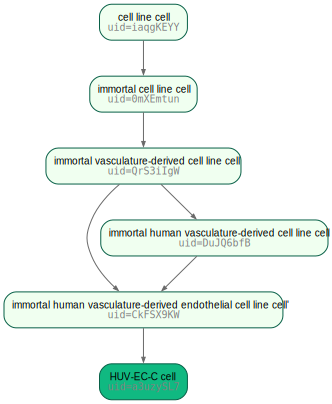

In [14]:
cell_lines = lb.CellLine.lookup(field="abbr")
cell_lines.huvec.view_parents()

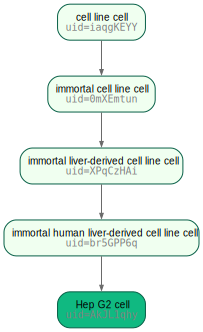

In [15]:
cell_lines.hepg2.view_parents()

### `split`

Use `ULabel` for "train", "test":

In [16]:
meta["split"].unique()

array(['test', 'train'], dtype=object)

In [17]:
train_test = [
    ln.ULabel(name=name, description="ML split") for name in meta["split"].unique()
]
ln.save(train_test)

Define a parent:

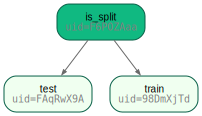

In [18]:
is_split = ln.ULabel(name="is_split", description="ML split")
is_split.save()
is_split.children.add(*train_test)
is_split.view_parents(with_children=True)

### `experiment`

In [19]:
ln.settings.upon_create_search_name = False
experiments = [
    ln1.Experiment(name=name, description="RxRx1")
    for name in meta["experiment"].unique()
]
ln.save(experiments)
ln.settings.upon_create_search_name = True

### `plate`

In [20]:
is_plate = ln.ULabel(name="is_plate", description="parent of plates")
is_plate.save()
plates = [ln.ULabel(name=f"Plate{name}") for name in meta["plate"].unique()]
ln.save(plates)
is_plate.children.set(plates)

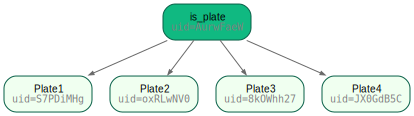

In [21]:
is_plate.view_parents(with_children=True)

### `well`

We might also want to add the well information, so that we can link image files and parse images based on well coordinates. To do this, let's first extract well locations from the table:

In [22]:
ln.settings.upon_create_search_name = False
wells = [
    ln1.Well(name=well, row=well[0], column=int(well[1:]))
    for well in meta["well"].unique()
]
ln.save(wells)
ln.settings.upon_create_search_name = True

### `well_type`

In [23]:
is_well_type = ln.ULabel(name="is_well_type", description="parent of well types")
is_well_type.save()

In [24]:
well_types = [ln.ULabel(name=name) for name in meta["well_type"].unique()]
ln.save(well_types)
is_well_type.children.set(well_types)

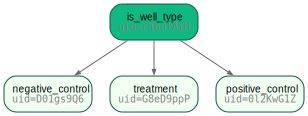

In [25]:
is_well_type.view_parents(with_children=True)

### `sirna`

Add `sirna` to Treatment table:

In [26]:
ln.settings.upon_create_search_name = False
sirnas = [
    ln1.Treatment(
        name=sirna,
        type="genetic",
        system="siRNA",
        description="ThermoFisher ID of siRNA",
    )
    for sirna in meta["sirna"].unique()
]
ln.save(sirnas)
ln.settings.upon_create_search_name = True

### `readout`

In [27]:
ln.Feature(name="readout", type="category").save()
readout = lb.ExperimentalFactor.from_bionty(name="high content screen")
readout.save()

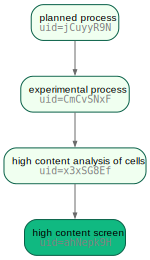

In [28]:
readout.view_parents(with_children=True)

## Register all metadata features

Here we create a DataFrame with each row as a single image, similar to a link table but with multiple metadata columns:

In [29]:
meta_with_path = meta.copy()
keys_list = []
for key in meta_with_path["paths"]:
    keys = [key.replace("w1-w6.png", f"w{str(channel)}.png") for channel in range(1, 7)]
    keys_list.append(keys)
meta_with_path["path"] = keys_list
meta_with_path = meta_with_path.explode("path").reset_index(drop=True)
del meta_with_path["paths"]
meta_with_path

,site_id,well_id,cell_line,split,experiment,plate,well,site,well_type,sirna,sirna_id,path
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w1.png
1,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w2.png
2,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w3.png
3,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w4.png
4,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w5.png
...,...,...,...,...,...,...,...,...,...,...,...,...
753055,U2OS-03_4_O23_2,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,2,treatment,s21454,509,images/train/U2OS-03/Plate4/O23_s2_w2.png
753056,U2OS-03_4_O23_2,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,2,treatment,s21454,509,images/train/U2OS-03/Plate4/O23_s2_w3.png
753057,U2OS-03_4_O23_2,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,2,treatment,s21454,509,images/train/U2OS-03/Plate4/O23_s2_w4.png
753058,U2OS-03_4_O23_2,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,2,treatment,s21454,509,images/train/U2OS-03/Plate4/O23_s2_w5.png


Here we register all metadata features:

In [30]:
obs_features = ln.Feature.from_df(
    meta_with_path[
        [
            "cell_line",
            "split",
            "experiment",
            "plate",
            "well",
            "well_type",
            "sirna",
            "path",
        ]
    ]
)
ln.save(obs_features)

In [31]:
ln.Feature.filter().df()

,uid,name,type,unit,description,registries,synonyms,updated_at,created_by_id
id,,,,,,,,,
4,QRDI6GPwJXUi,cell_line,category,None,None,bionty.CellLine,None,2023-11-05 17:08:02.833049+00:00,1
5,7Fu3r6Oqlu54,split,category,None,None,core.ULabel,None,2023-11-05 17:08:04.072217+00:00,1
6,oJ4yMuWHSyHN,experiment,category,None,None,lamin1.Experiment,None,2023-11-05 17:08:05.213061+00:00,1
7,kCK1qPgf3koy,plate,number,None,None,core.ULabel,None,2023-11-05 17:08:06.439267+00:00,1
8,qka3fPyvXUhM,well,category,None,None,lamin1.Well,None,2023-11-05 17:08:07.581034+00:00,1
10,MeViaVFT7MMO,well_type,category,None,None,core.ULabel,None,2023-11-05 17:08:10.088877+00:00,1
11,o9daNbNPBP8t,sirna,category,None,None,lamin1.Treatment,None,2023-11-05 17:08:11.289557+00:00,1
14,Fqt7swNFOXdV,path,object,None,None,None,None,2023-11-05 17:57:28.857915+00:00,1
1,xjFyZiG6VjzJ,readout,category,None,None,bionty.ExperimentalFactor,None,2023-11-15 05:54:46.044131+00:00,1


In [32]:
features = ln.Feature.lookup()

## Register metadata file

In [33]:
meta_file = ln.File.from_df(
    meta_with_path,
    field=ln.Feature.name,
    key="rxrx1/metadata.parquet",
    description="Metadata with file paths for each RxRx1 image.",
)

❗ 4 terms (33.30%) are not validated for name: site_id, well_id, site, sirna_id


In [34]:
meta_file.save()

... uploading yhJ3uqDZRI4wE7xnoOMz.parquet: 1.00


Annotate with labels:

In [35]:
cell_lines = lb.CellLine.from_values(meta.cell_line.unique())

In [36]:
# columns
meta_file.labels.add(cell_lines, features.cell_line)
meta_file.labels.add(train_test, features.split)
meta_file.labels.add(experiments, features.experiment)
meta_file.labels.add(plates, features.plate)
meta_file.labels.add(wells, features.well)
meta_file.labels.add(well_types, features.well_type)
meta_file.labels.add(sirnas, features.sirna)
# external
meta_file.labels.add(readout, features.readout)

In [37]:
meta_file.describe()

File(uid='yhJ3uqDZRI4wE7xnoOMz', key='rxrx1/metadata.parquet', suffix='.parquet', accessor='DataFrame', description='Metadata with file paths for each RxRx1 image.', size=5722206, hash='BzgFQG5HKTIkM7JfEWU-_A', hash_type='md5', visibility=0, key_is_virtual=True, updated_at=2023-11-15 05:54:55 UTC)

Provenance:
  🗃️ storage: Storage(uid='DxIABGjc', root='s3://lamindata', type='s3', region='us-east-1', updated_at=2023-11-05 15:57:55 UTC, created_by_id=1)
  📔 transform: Transform(uid='Zo0qJt4IQPsbxM', name='Register the RxRx1 dataset', short_name='02-rxrx1', version='1', type='notebook', updated_at=2023-11-15 05:40:06 UTC, initial_version_id=3, created_by_id=1)
  👣 run: Run(uid='1wQSEWx8oK23GxLlAIHj', run_at=2023-11-15 05:48:27 UTC, transform_id=4, created_by_id=1)
  👤 created_by: User(uid='FBa7SHjn', handle='falexwolf', name='Alex Wolf', updated_at=2023-11-05 14:57:57 UTC)
Features:
  columns: FeatureSet(uid='y0uhIW520iTEzrxI14mL', n=8, registry='core.Feature', hash='mnhzsJj-j7VZgNJ88VM0

## Register dataset

In [38]:
collection = ln.Collection(
    "gs://rxrx1-europe-west4/images", name="RxRx1 images", meta=meta_file, version="1"
)
collection.save()

In [39]:
collection.labels.add_from(meta_file)

In [40]:
collection.describe()

Dataset(uid='flLeukogmLRzleFCpCRD', name='RxRx1 images', version='1', hash='4on4AbbmBL0sr0xe9_gxxQ', visibility=0, updated_at=2023-11-15 05:55:26 UTC)

Provenance:
  📄 file: File(uid='flLeukogmLRzleFCpCRD', suffix='.parquet', accessor='DataFrame', description='Metadata with file paths for each RxRx1 image.', size=7806003, hash='4on4AbbmBL0sr0xe9_gxxQ', hash_type='md5', visibility=0, key_is_virtual=True, updated_at=2023-11-15 05:55:25 UTC, storage_id=1, transform_id=3, run_id=2, created_by_id=1)
  🗃️ storage: Storage(uid='aLcXXffe', root='gs://rxrx1-europe-west4/images', type='gs', updated_at=2023-11-15 05:55:24 UTC, created_by_id=1)
  👤 created_by: User(uid='FBa7SHjn', handle='falexwolf', name='Alex Wolf', updated_at=2023-11-05 14:57:57 UTC)
Features:
  columns: FeatureSet(uid='y0uhIW520iTEzrxI14mL', n=8, registry='core.Feature', hash='mnhzsJj-j7VZgNJ88VM0', updated_at=2023-11-05 17:57:58 UTC, created_by_id=1)
    🔗 cell_line (4, bionty.CellLine): 'HUV-EC-C cell', 'U-2 OS cell', 'hTERT